In [183]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('fivethirtyeight')

from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Read Data

In [172]:
data_path = '../../input/'
df_detailed_results = pd.read_csv(data_path + 'NCAATourneyDetailedResults.csv')
df_compact_results = pd.read_csv(data_path + 'NCAATourneyCompactResults.csv')
df_seeds = pd.read_csv(data_path + 'NCAATourneySeeds.csv')
df_seasons = pd.read_csv(data_path + 'Seasons.csv')
df_teams = pd.read_csv(data_path + 'Teams.csv')

In [173]:
df_detailed_results.head()

Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  WFGM  WFGA  \
0    2003     134     1421      92     1411      84    N      1    32    69   
1    2003     136     1112      80     1436      51    N      0    31    66   
2    2003     136     1113      84     1272      71    N      0    31    59   
3    2003     136     1141      79     1166      73    N      0    29    53   
4    2003     136     1143      76     1301      74    N      1    27    64   

  ...   LFGA3  LFTM  LFTA  LOR  LDR  LAst  LTO  LStl  LBlk  LPF  
0 ...      31    14    31   17   28    16   15     5     0   22  
1 ...      16     7     7    8   26    12   17    10     3   15  
2 ...      28    14    21   20   22    11   12     2     5   18  
3 ...      17    12    17   14   17    20   21     6     6   21  
4 ...      21    15    20   10   26    16   14     5     8   19  

[5 rows x 34 columns]

In [174]:
df_compact_results.head()

Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
0    1985     136     1116      63     1234      54    N      0
1    1985     136     1120      59     1345      58    N      0
2    1985     136     1207      68     1250      43    N      0
3    1985     136     1229      58     1425      55    N      0
4    1985     136     1242      49     1325      38    N      0

In [175]:
df_seeds.head()

Season Seed  TeamID
0    1985  W01    1207
1    1985  W02    1210
2    1985  W03    1228
3    1985  W04    1260
4    1985  W05    1374

In [176]:
df_seasons.head()

Season     DayZero RegionW    RegionX    RegionY    RegionZ
0    1985  10/29/1984    East       West    Midwest  Southeast
1    1986  10/28/1985    East    Midwest  Southeast       West
2    1987  10/27/1986    East  Southeast    Midwest       West
3    1988   11/2/1987    East    Midwest  Southeast       West
4    1989  10/31/1988    East       West    Midwest  Southeast

In [177]:
df_teams.head()

TeamID     TeamName  FirstD1Season  LastD1Season
0    1101  Abilene Chr           2014          2018
1    1102    Air Force           1985          2018
2    1103        Akron           1985          2018
3    1104      Alabama           1985          2018
4    1105  Alabama A&M           2000          2018

# EDA

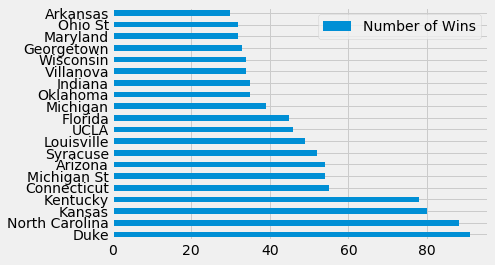

In [178]:
df_win_rank = df_compact_results.drop(labels=['DayNum', 'WScore', 'LTeamID', 'LScore', 'WLoc', 'NumOT'], axis=1)
def ID2Name(ID):
    return df_teams[df_teams.TeamID == ID].TeamName.values[0]
df_win_rank['WTeamName'] = df_win_rank.WTeamID.apply(ID2Name)
df_win_rank = df_win_rank.drop(labels=['Season', 'WTeamID'], axis=1)
df_win_rank = df_win_rank.apply(pd.value_counts).rename({'WTeamName': 'Number of Wins'}, axis='columns')
df_win_rank.head(n=20).plot.barh()

# Seeding Logistic Regression

In [179]:
def seed2Int(seed):
    s_int = int(seed[1:3])
    return s_int

df_seeds['Seed'] = df_seeds.Seed.apply(seed2Int)
df_seeds.head()

Season  Seed  TeamID
0    1985     1    1207
1    1985     2    1210
2    1985     3    1228
3    1985     4    1260
4    1985     5    1374

In [180]:
df_compact_results = df_compact_results.drop(labels=['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], axis=1)
df_compact_results.head()

Season  WTeamID  LTeamID
0    1985     1116     1234
1    1985     1120     1345
2    1985     1207     1250
3    1985     1229     1425
4    1985     1242     1325

In [181]:
df_win_seeds = df_seeds.rename(columns={'TeamID': 'WTeamID', 'Seed': 'WSeed'})
df_loss_seeds = df_seeds.rename(columns={'TeamID': 'LTeamID', 'Seed': 'LSeed'})
df_aux = pd.merge(left=df_compact_results, right=df_win_seeds, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_aux, right=df_loss_seeds, on=['Season', 'LTeamID'])
df_concat['SeedDiff'] = df_concat.WSeed - df_concat.LSeed
df_concat.head()

Season  WTeamID  LTeamID  WSeed  LSeed  SeedDiff
0    1985     1116     1234      9      8         1
1    1985     1120     1345     11      6         5
2    1985     1207     1250      1     16       -15
3    1985     1229     1425      9      8         1
4    1985     1242     1325      3     14       -11

In [182]:
df_wins = pd.DataFrame()
df_wins['SeedDiff'] = df_concat['SeedDiff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['SeedDiff'] = -df_concat['SeedDiff']
df_losses['Result'] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

SeedDiff  Result
0         1       1
1         5       1
2       -15       1
3         1       1
4       -11       1

In [185]:
X_train = df_predictions.SeedDiff.values.reshape(-1,1)
y_train = df_predictions.Result.values
X_train, y_train = shuffle(X_train, y_train)
X_train, y_train

(array([[  7],
        [ -4],
        [  1],
        ...,
        [  9],
        [-11],
        [ -1]]), array([0, 0, 1, ..., 0, 0, 0]))

In [186]:
logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.5531, with best C: 0.01


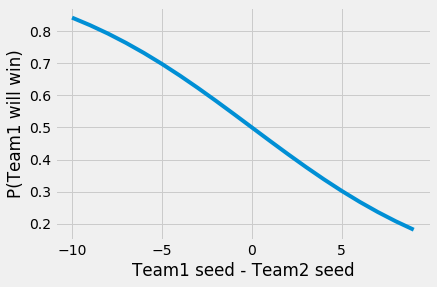

In [188]:
X = np.arange(-10, 10).reshape(-1, 1)
preds = clf.predict_proba(X)[:,1]

plt.plot(X, preds)
plt.xlabel('Team1 seed - Team2 seed')
plt.ylabel('P(Team1 will win)')
plt.show()

In [189]:
df_sample_sub = pd.read_csv('../../submissions/SampleSubmissionStage1.csv')
n_test_games = len(df_sample_sub)

def get_year_t1_t2(ID):
    """Return a tuple with ints `year`, `team1` and `team2`."""
    return (int(x) for x in ID.split('_'))

In [191]:
X_test = np.zeros(shape=(n_test_games, 1))
for ii, row in df_sample_sub.iterrows():
    year, t1, t2 = get_year_t1_t2(row.ID)
    t1_seed = df_seeds[(df_seeds.TeamID == t1) & (df_seeds.Season == year)].Seed.values[0]
    t2_seed = df_seeds[(df_seeds.TeamID == t2) & (df_seeds.Season == year)].Seed.values[0]
    diff_seed = t1_seed - t2_seed
    X_test[ii, 0] = diff_seed

In [192]:
preds = clf.predict_proba(X_test)[:,1]

clipped_preds = np.clip(preds, 0.05, 0.95)
df_sample_sub.Pred = clipped_preds
df_sample_sub.head()

ID      Pred
0  2014_1107_1110  0.458264
1  2014_1107_1112  0.075159
2  2014_1107_1113  0.268154
3  2014_1107_1124  0.157979
4  2014_1107_1140  0.268154

In [193]:
df_sample_sub.to_csv('../../submissions/logreg_seed_starter.csv', index=False)